### Анализ поведения пользователей онлайн игры

КЕЙС:

В приложении игры Quiz Freeze запущенно обновление. У разработчиков возникли гипотезы о поведении игроков, которые необходимо проверить. Использовать для анализа  нужно только данные пользователей, которые зарегистрировались в 2018 году.

ГИПОТЕЗЫ:

Гипотеза 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Гипотеза 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

Гипотеза 3
Если пользователь сначала выбирает уровень сложности, будет ли он потом проходить обучение?

ЗАДАЧИ:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ:
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна).

ЭТАПЫ ПРОХОЖДЕНИЯ ИГРЫ:
![](https://docs.google.com/drawings/d/e/2PACX-1vRtyzDIKtMjKP52C1ujIe-swMQNlgVhQ2kq6tws2IBZ2PkgILFxWoIvBf3854SXgDyeiSy6G7jE9O5G/pub?w=1444&h=150)

### <a name='link1'></a> Исходные данные
1. Таблица Event.
Хранит данные о событиях, которые совершают пользователи. По сути, каждое событие — это факт прохождения пользователем какого-либо этапа игры.

- Название поля: Описание
- id: идентификатор события
- user_id: уникальный идентификатор пользователя, совершившего событие в приложении
- start_time: дата и время события
- event_type: тип события (значения: registration — регистрация; tutorial_start — начало обучения; tutorial_finish — завершение обучения; level_choice — выбор уровня сложности; pack_choice — выбор пакетов вопросов)
 - tutorial_id: идентификатор обучения (этот идентификатор есть только у событий обучения) 
 - selected_level: выбранный уровень сложности обучения

2. Таблица purchase.
Хранит данные об оплатах, которые совершают пользователи.

- Название поля: Описание
- id: идентификатор события
- user_id: уникальный идентификатор пользователя, совершившего событие в приложении
- event_datetime: дата и время события/покупки
- amount: сумма оплаты

### <a name='link2'></a> Исследование и подготовка данных

Импортируем все необходимые библиотеки и модули

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Прочитаем исходные файлы 7_4_Events.csv, purchase.csv, сохраним их в переменных event_df и purchase_df.

In [235]:
# events_df = pd.read_csv('data/7_4_Events.csv')
# purchase_df = pd.read_csv('data/purchase.csv')
events_df = pd.read_csv('7_4_Events.csv')
purchase_df = pd.read_csv('purchase.csv')

Создадим маску correct_time для фильтрации пользователей зарегистрировавшихся в 2018 г.
На основе correct_time создадим список user_id зарегистрировавшихся в 2018 г. (users_2018).
Обновим events_df, оставляя в нём только необходимые события (фильтрация с помощью users_2018)
Обновим purchase_df, оставляя в нём только необходимые события (фильтрация с помощью users_2018)

In [236]:
correct_time = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] <'2019-01-01') & (events_df['event_type'] == 'registration')
users_2018 = events_df[correct_time]['user_id'].to_list()
events_df  = events_df[events_df['user_id'].isin(users_2018)]
purchase_df = purchase_df[purchase_df['user_id'].isin(users_2018)]


Переведем столбцы 'start_time' и 'event_datetime' в формат datetime.

In [237]:
events_df['start_time'] = pd.to_datetime (events_df['start_time'])
purchase_df['event_datetime'] = pd.to_datetime (purchase_df['event_datetime'])


Изучим данные в  полученных датасетах:


In [238]:
events_df.info()
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          

Удалим потенциальные повторы

In [239]:
purchase_df.drop_duplicates()
events_df.drop_duplicates()

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
...,...,...,...,...,...,...
118359,147262,tutorial_start,NaN,2019-01-01 03:26:18,49554.0,47756
118360,147263,tutorial_finish,NaN,2019-01-01 03:29:25,49554.0,47756
118362,147265,level_choice,easy,2019-01-01 05:04:52,NaN,47755
118363,147266,level_choice,medium,2019-01-01 05:42:11,NaN,47756


Изучим данных в столбцах:
    количество уникальных пользователей,
    уникальные значения столбца selected_level,
    уникальные значения столбца event_type.
    

In [240]:

print(events_df['user_id'].nunique())
print(events_df['selected_level'].unique())
print(events_df['event_type'].unique())

19926
[nan 'medium' 'hard' 'easy']
['registration' 'tutorial_start' 'tutorial_finish' 'level_choice'
 'pack_choice']


Шапки полученных таблиц

In [241]:
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836


In [242]:
purchase_df.head()

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200


Подготовим events_df и purchase_df к корректному объединению: переименуем столбцы, создадим новые.

In [243]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

Объеденим по методу concat, сбросим индексы и отсортируем по возростанию 'start_time'

In [244]:
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

Сохраним total_events_df для работы гипотезами.

In [245]:
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


### <a name='link3'></a> Проверка 1-ой гипотезы. Зависимость обучения и скорости прохождения этапов игры

Создадим списки пользователей которые:
завершили обучение; начинали обучение; начинали играть; начинали играть пропустив обучение (путем вычитания множеств)

In [246]:
finished_tut = events_df[events_df['event_type'] == 'tutorial_finish']['user_id'].tolist()
users_started_tut = events_df[events_df['event_type'] == 'tutorial_start']['user_id'].tolist()
users_started_play = events_df[events_df['event_type'] == 'level_choice']['user_id'].tolist()
never_started_tut = list(set(users_started_play).difference(set(users_started_tut)))

Скопируем new_total_events для работы с 1-ой гипотезой

In [247]:
new_total_events=total_events_df

Построим сводную таблицу, в которой столбцами будут этапы прохождения игры, индексами - user_id, значениями - 'start_time'

In [248]:
new_total_events = new_total_events.pivot_table (
    values='start_time',
    index='user_id',
    columns='event_type'
     , aggfunc='min' 
)
new_total_events = new_total_events.reset_index()

Создадим функцию type_of_user для определения категории пользователя (обучался, не обучался, остальные)

In [249]:
def type_of_user (id):
    if id in (finished_tut):
        return 'finished_tut'
    if id in (never_started_tut):
        return 'never_started_tut'
    else:
        return 'other'

Применим фун-ию type_of_user для создания нового признака user_type. Отфильтруем df убрав все записи категории 'other', оставив тем самым только интересующие нас категории пользователей.

In [250]:
new_total_events['user_type'] = new_total_events.user_id.apply(type_of_user)
new_total_events = new_total_events[new_total_events['user_type']!='other']

Создадим 3 новых столбца : level_pack_timedelta - время на прохождение этапа между выбором уровня сложности и выбором пакета вопросов; pack_purchase_timedelta - время на прохождение этапа между выбором пакета вопросов и покупкой ; regist_purchase_timedelta - время на прохождение этапа между регистрацией и покупкой.

In [251]:
new_total_events['level_pack_timedelta'] = new_total_events['pack_choice'] - new_total_events['level_choice']
new_total_events['pack_purchase_timedelta'] = new_total_events['purchase'] - new_total_events['pack_choice']
new_total_events['regist_purchase_timedelta'] = new_total_events['purchase'] - new_total_events['registration']

Переведем значения timedelta в числовые. В минуты - для этапа level_pack_timedelta. В дни - для этапа pack_purchase_timedelta и regist_purchase_timedelta.

In [252]:
new_total_events['level_pack_timedelta'] = new_total_events['level_pack_timedelta']/pd.Timedelta('1 minute')
new_total_events['pack_purchase_timedelta'] = new_total_events['pack_purchase_timedelta']/pd.Timedelta('1 day')
new_total_events['regist_purchase_timedelta'] = new_total_events['regist_purchase_timedelta']/pd.Timedelta('1 day')


Оставим только интересующие нас столбцы

In [253]:
new_total_events = new_total_events[['user_id','user_type','level_pack_timedelta','pack_purchase_timedelta','regist_purchase_timedelta']]


Сгруппируем данные по типам пользователей и посчитаем среднее время прохождения каждого этапа.

In [254]:
level_pack = new_total_events.groupby('user_type')['level_pack_timedelta'].mean()
pack_purchase = new_total_events.groupby('user_type')['pack_purchase_timedelta'].mean()
regist_purchase = new_total_events.groupby('user_type')['regist_purchase_timedelta'].mean()

In [255]:
level_pack

user_type
finished_tut         5.302434
never_started_tut    5.397072
Name: level_pack_timedelta, dtype: float64

In [256]:
pack_purchase

user_type
finished_tut         3.720829
never_started_tut    4.201083
Name: pack_purchase_timedelta, dtype: float64

In [257]:
regist_purchase

user_type
finished_tut         4.020871
never_started_tut    4.379189
Name: regist_purchase_timedelta, dtype: float64

Для визуализации результатов используем метод Subplots(). Для каждого этапа игры создадим отдельную столбчатую диаграмму.

Text(0.5, 0, 'Группы пользователей')

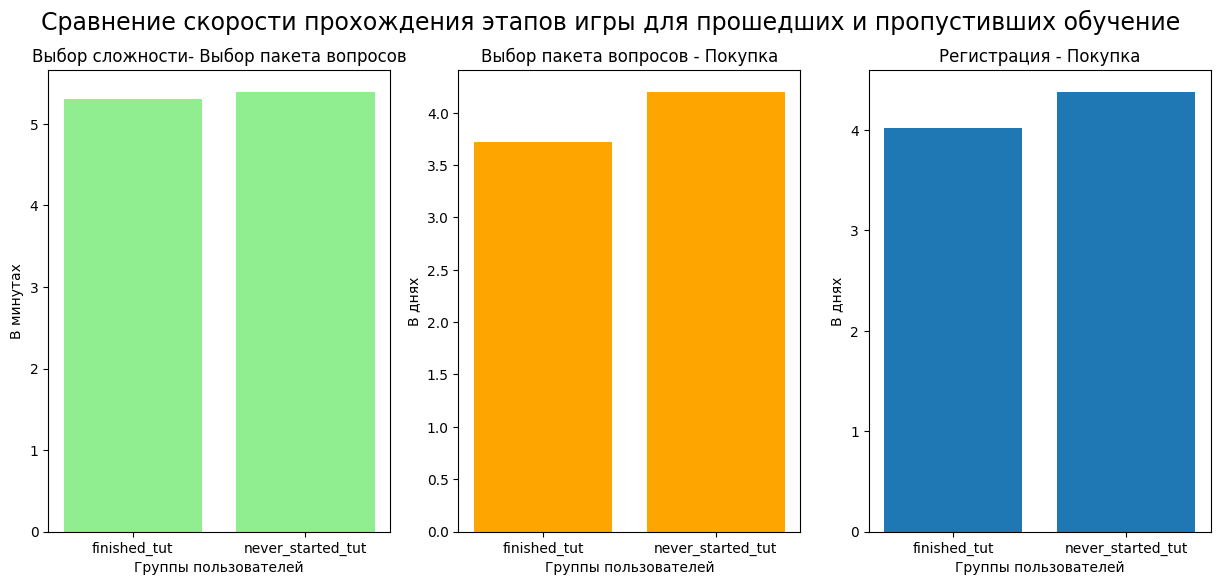

In [258]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle("Сравнение скорости прохождения этапов игры для прошедших и пропустивших обучение", fontsize=17)
axes[0].bar(x=level_pack.index, 
    height=level_pack,
    color='lightgreen',
)
axes[0].set_title('Выбор сложности- Выбор пакета вопросов')
axes[0].set_ylabel('В минутах')
axes[0].set_xlabel('Группы пользователей')

axes[1].bar(x=pack_purchase.index, 
    height=pack_purchase,
    color='orange',
)
axes[1].set_title('Выбор пакета вопросов - Покупка')
axes[1].set_ylabel('В днях')
axes[1].set_xlabel('Группы пользователей')

axes[2].bar(x=regist_purchase.index, 
    height=regist_purchase,
)
axes[2].set_title('Регистрация - Покупка')
axes[2].set_ylabel('В днях')
axes[2].set_xlabel('Группы пользователей')

-для проверки гипотезы выявлены 2 группы пользователей: **Finished_tut** - завершившие обучение; **Never_started_tut** - не начинавшие обучение.

-для этих групп сравнивалась скорость прохождения 3-ёх этапов:

 1 - время от выбора уровня сложности до выбора пакета вопросов;
 
 2 - время от выбора пакета вопросов до покупки;

 3 - время от регистрации до покупки

### <a name='link4'></a> Выводы по 1-ой гипотезе

-разница для сравниваемых групп в прохождении первого этапа практически отсутствует (5.3 и 5.4 минуты);

-разница в прохождении второго этапа присутствует (3.7 и 4.2 дня). **Пользователи завершившие обучение быстрее (на 14%) проходят этап от выбора пакета вопросов до покупки**;

-разница в прохождении третьего этапа присутствует (4 и 4.4 дня). **Пользователи завершившие обучение быстрее (на 10%) проходят этап  от регистрации до покупки**



### <a name='link5'></a> Проверка 2-ой гипотезы. Зависимость обучения и покупки платных вопросов

Находим уникальный путь каждого пользователя

In [259]:
user_path_df = (
    total_events_df.groupby(["user_id"])["event_type"].apply(list).reset_index()
)
user_path_df.head()

,user_id,event_type
0,27832,[registration]
1,27833,"[registration, tutorial_start, tutorial_finish]"
2,27834,"[registration, tutorial_start, tutorial_finish]"
3,27835,"[registration, tutorial_start, tutorial_finish..."
4,27836,"[registration, tutorial_start, tutorial_start,..."


Преобразуем event_path для более удобного использования

In [260]:
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))
user_path_df.head()

,user_id,event_type,event_path
0,27832,[registration],registration
1,27833,"[registration, tutorial_start, tutorial_finish]",registration > tutorial_start > tutorial_finish
2,27834,"[registration, tutorial_start, tutorial_finish]",registration > tutorial_start > tutorial_finish
3,27835,"[registration, tutorial_start, tutorial_finish...",registration > tutorial_start > tutorial_finis...
4,27836,"[registration, tutorial_start, tutorial_start,...",registration > tutorial_start > tutorial_start...


Оставляем только пользователей с покупкой, удаляем лишний столбец 'event_type', сбрасываем индексы

In [261]:
user_path_df_with_purchase = user_path_df[user_path_df['event_path'].str.contains('purchase')]
user_path_df_with_purchase = user_path_df_with_purchase[['user_id','event_path']].reset_index(drop=True)
user_path_df_with_purchase.head()

,user_id,event_path
0,27845,registration > tutorial_start > tutorial_finis...
1,27865,registration > tutorial_start > level_choice >...
2,27884,registration > tutorial_start > tutorial_finis...
3,27910,registration > tutorial_start > tutorial_finis...
4,27911,registration > tutorial_start > level_choice >...


Создаем новые столбцы,в которых подсчитано кол-во 'tutorial_start' и 'tutorial_finish'

In [262]:
user_path_df_with_purchase['starts_count'] = user_path_df_with_purchase.event_path.str.count('tutorial_start')
user_path_df_with_purchase['finishes_count'] = user_path_df_with_purchase.event_path.str.count('tutorial_finish')
user_path_df_with_purchase.head()


,user_id,event_path,starts_count,finishes_count
0,27845,registration > tutorial_start > tutorial_finis...,2,2
1,27865,registration > tutorial_start > level_choice >...,1,0
2,27884,registration > tutorial_start > tutorial_finis...,3,2
3,27910,registration > tutorial_start > tutorial_finis...,1,1
4,27911,registration > tutorial_start > level_choice >...,1,0


Создаем функцию category_func,чтобы выделить 4 категории: 
- 'обучение начато, но не закончено' 
- 'обучение начато и закончено'
- 2 и более обучений начато и закончено'
- 'без обучения'

In [263]:
def category_func(row):
    if row['starts_count']>=1 and row['finishes_count']==0:
        return 'обучение начато, но не закончено'
    if row['starts_count']==1 and row['finishes_count']==1:
        return 'обучение начато и закончено'
    if row['starts_count']>=2 and row['finishes_count']>=1:
        return '2 и более обучений начато и закончено'
    else:
        return 'без обучения'
    

Создаем новый столбец category с помощью функции category_func.

In [264]:
user_path_df_with_purchase['category'] = user_path_df_with_purchase.apply(category_func,axis=1)
user_path_df_with_purchase.head()

,user_id,event_path,starts_count,finishes_count,category
0,27845,registration > tutorial_start > tutorial_finis...,2,2,2 и более обучений начато и закончено
1,27865,registration > tutorial_start > level_choice >...,1,0,"обучение начато, но не закончено"
2,27884,registration > tutorial_start > tutorial_finis...,3,2,2 и более обучений начато и закончено
3,27910,registration > tutorial_start > tutorial_finis...,1,1,обучение начато и закончено
4,27911,registration > tutorial_start > level_choice >...,1,0,"обучение начато, но не закончено"


В новой categories_df группируем данные по категориям и подсчитываем кол-во пользователей в каждой из них.

In [265]:
categories_df = user_path_df_with_purchase.groupby('category')['user_id'].count().sort_values(ascending=False)
categories_df.head()

category
обучение начато и закончено              1083
2 и более обучений начато и закончено     364
обучение начато, но не закончено          131
без обучения                               22
Name: user_id, dtype: int64

Создаем круговую диаграмму на основе библиотеки Matplotlib.

Text(0.5, 1.0, 'Категории пользователей совершавших оплату (зависимость от обучения)')

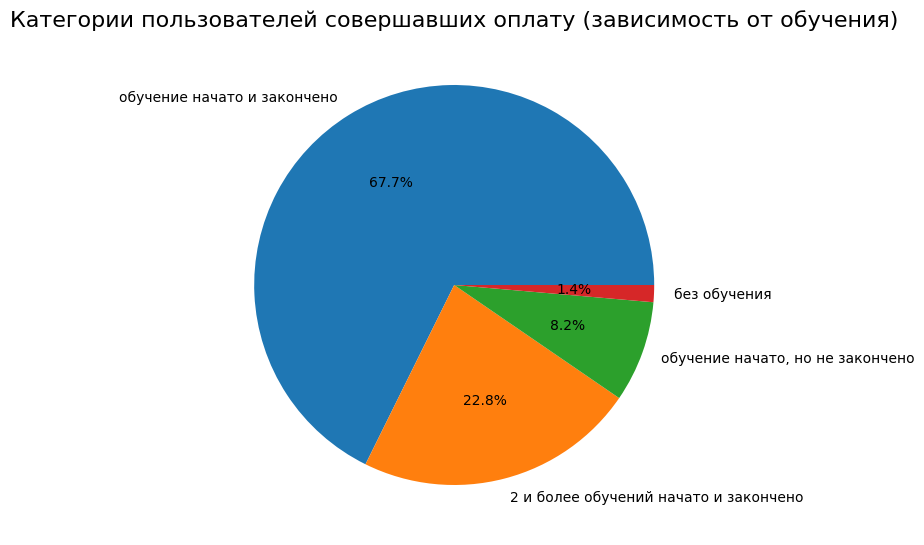

In [266]:
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    categories_df,
    labels=categories_df.index,
    autopct='%.1f%%',
);
axes.set_title('Категории пользователей совершавших оплату (зависимость от обучения)', fontsize=16)

### <a name='link6'></a> Выводы по 2-ой гипотезе

-**законченное** обучение является залогом дальнейших покупок;

-**повторное** обучение составляет только 22% по сравнению с 67% **одноразового**. Т.е. не так важно сколько было попыток обучения, важно, чтобы они были завершены;

-незаконченное обучение - лучше чем, его отсутствие (8.2% по сравнению с 1.4%);

-пропустив этап обучения, пользователь почти наверняка НЕ совершит покупку.


### <a name='link7'></a> Проверка 3-ей гипотезы. Насколько прозрачен процесс взаимодействия с игрой

Воспользуемся созданной ранее total_events_df.

In [267]:
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0



Создадим сводную new_total_events_3, где отобразим самое ранее ('min') время для всех событий ('event_type'). Удалим лишние столбцы, сбросим индекс, удалим пропуски. В результате получаем только тех пользователей, которые дошли до этапа 'level_choice', т.е. начали играть.

In [268]:
new_total_events_3 = total_events_df.pivot_table (
    values='start_time',
    index='user_id',
    columns='event_type'
     , aggfunc='min' 
)
new_total_events_3 = new_total_events_3.reset_index()
new_total_events_3 = new_total_events_3.drop(['pack_choice','purchase','registration','tutorial_finish','tutorial_start'],axis=1)
new_total_events_3 = new_total_events_3.dropna(axis=0)
new_total_events_3

event_type,user_id,level_choice
3,27835,2018-01-01 20:37:22
7,27839,2018-01-01 22:37:50
8,27840,2018-01-02 05:18:42
10,27842,2018-01-02 08:46:03
11,27843,2018-01-02 14:09:58
...,...,...
19912,47744,2018-12-31 07:53:04
19915,47747,2018-12-31 12:24:40
19921,47753,2018-12-31 22:36:19
19923,47755,2019-01-01 05:04:52


Создадим сводную new_total_events_4, где отобразим самое позднее ('max') время для всех событий ('event_type'). Удалим лишние столбцы, сбросим индекс. В результате получаем пользователей и самое позднее время для начала обучения.

In [269]:
new_total_events_4 = total_events_df.pivot_table (
    values='start_time',
    index='user_id',
    columns='event_type'
     , aggfunc='max' 
)
new_total_events_4 = new_total_events_4.reset_index()
new_total_events_4 = new_total_events_4.drop(['pack_choice','purchase','registration','tutorial_finish','level_choice'],axis=1)
new_total_events_4

event_type,user_id,tutorial_start
0,27832,NaT
1,27833,2018-01-01 17:47:40
2,27834,2018-01-01 19:46:11
3,27835,2018-01-01 15:00:51
4,27836,2018-01-01 15:40:43
...,...,...
19921,47753,2018-12-31 20:54:56
19922,47754,NaT
19923,47755,2019-01-01 00:08:14
19924,47756,2019-01-01 03:26:18


Объеденим таблицы по принципу 'left', т.е. оставим только активных игроков. Вычислим time_delta - разницу во времени между обучением и началом игры. Приведем time_delta к числовому значению (в минутах).

In [270]:
new_total_events_5 = new_total_events_3.merge(new_total_events_4,on='user_id',how='left')
new_total_events_5['time_delta'] = new_total_events_5['tutorial_start']-new_total_events_5['level_choice']
new_total_events_5['time_delta'] = new_total_events_5['time_delta']/pd.Timedelta('1 minute')
new_total_events_5

event_type,user_id,level_choice,tutorial_start,time_delta
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51,-336.516667
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36,-206.233333
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07,-191.583333
3,27842,2018-01-02 08:46:03,2018-01-02 18:08:01,561.966667
4,27843,2018-01-02 14:09:58,2018-01-02 13:34:51,-35.116667
...,...,...,...,...
8337,47744,2018-12-31 07:53:04,2018-12-31 06:51:17,-61.783333
8338,47747,2018-12-31 12:24:40,2018-12-31 10:21:11,-123.483333
8339,47753,2018-12-31 22:36:19,2018-12-31 20:54:56,-101.383333
8340,47755,2019-01-01 05:04:52,2019-01-01 00:08:14,-296.633333


Создадим функцию для определения типа игрока. Если time_delta больше нуля, значит пользователь начинал играть, а потом вернулся к этапу обучения. В категории 'прочие' - множество других вариантов, которые не имеют значения для проверки 3-ей гипотезы.

In [271]:
def get_type_user(x):
    if x>0:
        return 'вернулся к обучению после игры'
    else:
        return 'прочие'
    

Создадим столбец type_of_user используя функцию get_type_user. Сгруппируем по type_of_user и подсчитаем кол-во игроков по категориям.

In [272]:
new_total_events_5['type_of_user'] = new_total_events_5['time_delta'].apply(get_type_user)
new_total_events_5 = new_total_events_5.groupby(['type_of_user'])['user_id'].count()
new_total_events_5

type_of_user
вернулся к обучению после игры    1386
прочие                            6956
Name: user_id, dtype: int64

Создадим круговую диаграмму с помощью библиотеки matplotlib.

Text(0.5, 1.0, 'Поведение пользователей (с точки зрения ясности прохождения игры)')

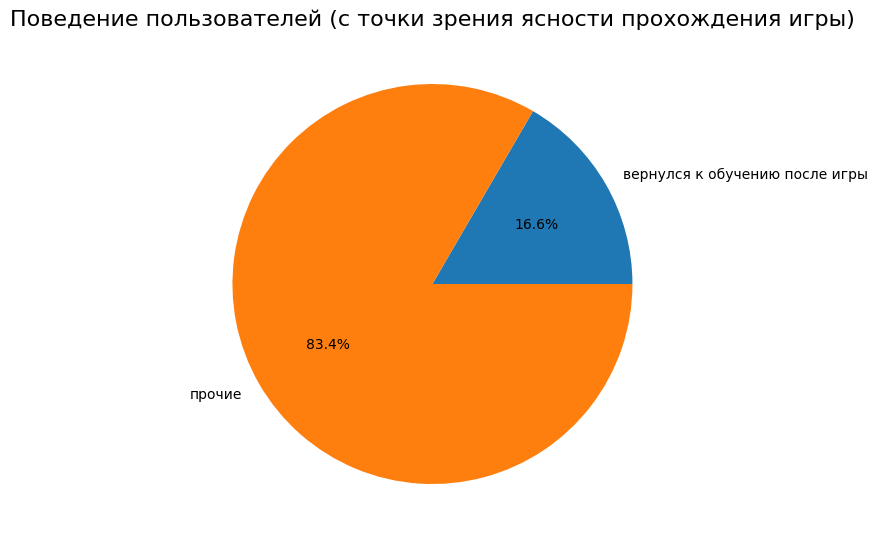

In [273]:
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    new_total_events_5,
    labels=new_total_events_5.index,
    autopct='%.1f%%',
);
axes.set_title('Поведение пользователей (с точки зрения ясности прохождения игры)', fontsize=16)

###  <a name='link8'></a> Выводы по 3-ей гипотезе

-Для проверки гипотезы рассматривались только игроки начинавшие игру хотя бы один раз (дошли до этапа level_choice).
Среди них **16,6%  - в дальнейшем вернулись к обучению** (в первый раз или повторно). Можно сделать вывод, что процесс взаимодействия с игрой достаточно прозрачен, но есть потенциал для его совершенствования.



### <a name='link9'></a> Финальные выводы и рекомендации


### Гипотеза 1

- Не прослеживается явной связи между обучением и скоростью прохождения этапов игры.

- Пользователи завершившие обучение (по сравнению с не проходившими)чуть быстрее доходят до покупки. От этапа выбора пакета вопросов на 14%, от этапа регистрации на 10%.


### Гипотеза 2

- Завершенное обучение безусловно положительно влияет на покупки (90.5% всех оплат). При этом повторное обучение значительно уступает первичному, т.е. не является важным фактором.

### Гипотеза 3

- Процесс взаимодействия с игрой достаточно ясен и прозрачен. Процент возвращающихся к этапу обучения - 16,6%, т.е. есть потенциал для совершенствования.

### Рекомендации

- Сразу после регистрации сосредоточить внимание пользователя на обучении и поощрять его успешное окончание.

- Усовершенствовать процесс взаимодействия с игрой, сделать его еще более прозрачным и ясным.

